# Training a neural network on MNIST with Keras

This simple example demonstrates how to plug TensorFlow Datasets (TFDS) into a Keras model.


Copyright 2020 The TensorFlow Datasets Authors, Licensed under the Apache License, Version 2.0

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/datasets/keras_example"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/datasets/blob/master/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/datasets/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

2022-08-18 16:37:52.965600: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-18 16:37:52.965806: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/tim/Dokumente/Projects/jupyterLab/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 1: Create your input pipeline

Start by building an efficient input pipeline using advices from:
* The [Performance tips](https://www.tensorflow.org/datasets/performances) guide
* The [Better performance with the `tf.data` API](https://www.tensorflow.org/guide/data_performance#optimize_performance) guide


### Load a dataset

Load the MNIST dataset with the following arguments:

* `shuffle_files=True`: The MNIST data is only stored in a single file, but for larger datasets with multiple files on disk, it's good practice to shuffle them when training.
* `as_supervised=True`: Returns a tuple `(img, label)` instead of a dictionary `{'image': img, 'label': label}`.

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'emnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

2022-08-18 16:38:03.465303: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-18 16:38:03.465505: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-18 16:38:03.465573: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (VirtDebian): /proc/driver/nvidia/version does not exist
2022-08-18 16:38:03.480070: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Build a training pipeline

Apply the following transformations:

* `tf.data.Dataset.map`: TFDS provide images of type `tf.uint8`, while the model expects `tf.float32`. Therefore, you need to normalize images.
* `tf.data.Dataset.cache` As you fit the dataset in memory, cache it before shuffling for a better performance.<br/>
__Note:__ Random transformations should be applied after caching.
* `tf.data.Dataset.shuffle`: For true randomness, set the shuffle buffer to the full dataset size.<br/>
__Note:__ For large datasets that can't fit in memory, use `buffer_size=1000` if your system allows it.
* `tf.data.Dataset.batch`: Batch elements of the dataset after shuffling to get unique batches at each epoch.
* `tf.data.Dataset.prefetch`: It is good practice to end the pipeline by prefetching [for performance](https://www.tensorflow.org/guide/data_performance#prefetching).

In [3]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

### Build an evaluation pipeline

Your testing pipeline is similar to the training pipeline with small differences:

 * You don't need to call `tf.data.Dataset.shuffle`.
 * Caching is done after batching because batches can be the same between epochs.

In [4]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

2022-08-18 16:38:33.311060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 19586 of 697932
2022-08-18 16:38:43.311716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 42484 of 697932
2022-08-18 16:38:53.311188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 65563 of 697932
2022-08-18 16:39:03.311150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 85622 of 697932
2022-08-18 16:39:13.311209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 106692 of 697932
2022-08-18 16:39:23.311013: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 126841 of 697932
2022-08-18 16:39:33.311043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc

<class 'tuple'>
(28, 28, 1)
(128,)


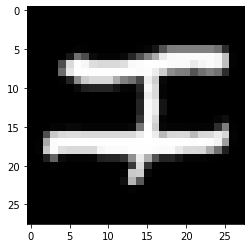

17 H


In [5]:
import matplotlib.pyplot as plt
charList = ['0','1','2','3','4','5','6','7','8','9',
'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']


#print(ds_train.inspect)
#dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
for element in ds_train:
    #print(element)
    break
for element in ds_train.as_numpy_iterator():
    print(type(element))
    element1, element2 = element
    print(element1[0].shape)
    print(element2.shape)
    plt.imshow(element1[0], cmap='gray') #Bilder sind gedreht und gespiegelt
    plt.show()
    print(element2[0], charList[element2[0]])
    break


## Step 2: Create and train the model

Plug the TFDS input pipeline into a simple Keras model, compile the model, and train it.

In [6]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(62, "softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    #optimizer=tf.keras.optimizers.Adam(0.001),
    #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=30,
    validation_data=ds_test,
    callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath='tfKerasCharsEMNISTSoftmax', save_best_only=True, monitor="val_loss"),
               tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)]
)

Epoch 1/30
5452/5453 [============================>.] - ETA: 0s - loss: 0.7731 - sparse_categorical_accuracy: 0.7683

2022-08-18 16:48:29.409093: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: tfKerasCharsEMNISTSoftmax/assets


INFO:tensorflow:Assets written to: tfKerasCharsEMNISTSoftmax/assets


5453/5453 [==============================] - 124s 22ms/step - loss: 0.7731 - sparse_categorical_accuracy: 0.7683 - val_loss: 0.5987 - val_sparse_categorical_accuracy: 0.8088
Epoch 2/30
5453/5453 [==============================] - ETA: 0s - loss: 0.5741 - sparse_categorical_accuracy: 0.8157INFO:tensorflow:Assets written to: tfKerasCharsEMNISTSoftmax/assets


INFO:tensorflow:Assets written to: tfKerasCharsEMNISTSoftmax/assets


5453/5453 [==============================] - 77s 14ms/step - loss: 0.5741 - sparse_categorical_accuracy: 0.8157 - val_loss: 0.5688 - val_sparse_categorical_accuracy: 0.8185
Epoch 3/30
5450/5453 [============================>.] - ETA: 0s - loss: 0.5517 - sparse_categorical_accuracy: 0.8219INFO:tensorflow:Assets written to: tfKerasCharsEMNISTSoftmax/assets


INFO:tensorflow:Assets written to: tfKerasCharsEMNISTSoftmax/assets


5453/5453 [==============================] - 72s 13ms/step - loss: 0.5517 - sparse_categorical_accuracy: 0.8219 - val_loss: 0.5568 - val_sparse_categorical_accuracy: 0.8230
Epoch 4/30
5453/5453 [==============================] - 71s 13ms/step - loss: 0.5458 - sparse_categorical_accuracy: 0.8242 - val_loss: 0.5642 - val_sparse_categorical_accuracy: 0.8208
Epoch 5/30
5453/5453 [==============================] - 70s 13ms/step - loss: 0.5474 - sparse_categorical_accuracy: 0.8245 - val_loss: 0.5996 - val_sparse_categorical_accuracy: 0.8043
Epoch 6/30
5453/5453 [==============================] - 70s 13ms/step - loss: 0.5512 - sparse_categorical_accuracy: 0.8237 - val_loss: 0.5856 - val_sparse_categorical_accuracy: 0.8215
Epoch 7/30
5453/5453 [==============================] - 73s 13ms/step - loss: 0.5571 - sparse_categorical_accuracy: 0.8228 - val_loss: 0.6016 - val_sparse_categorical_accuracy: 0.8114
Epoch 8/30
5453/5453 [==============================] - 70s 13ms/step - loss: 0.5638 - spar

In [7]:
converter = tf.lite.TFLiteConverter.from_saved_model('tfKerasCharsEMNISTSoftmax')
tflite_model = converter.convert()

with open("tfKerasCharsEMNISTSoftmax.tflite", "wb") as fp:
    fp.write(tflite_model)

2022-08-18 17:36:55.806892: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-08-18 17:36:55.806974: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-08-18 17:36:55.810073: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: tfKerasCharsEMNISTSoftmax
2022-08-18 17:36:55.814254: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-08-18 17:36:55.814364: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: tfKerasCharsEMNISTSoftmax
2022-08-18 17:36:55.839865: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-08-18 17:36:55.989313: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: tfKerasCharsEMNISTSoftmax
2022-08-18 17:36:56.045271: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 62)                7998      
                                                                 
Total params: 108,478
Trainable params: 108,478
Non-trainable params: 0
_________________________________________________________________
Element1 Shape (28, 28, 1)
Ergebnis Shape (1, 62)
Zeichen unmapped 28 Zeichen mapped S Ergebnis 0.88363343
Element 28


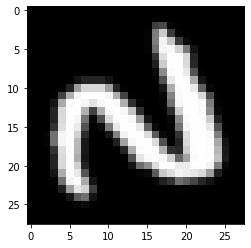

In [8]:
import numpy as np
import tensorflow as tf

charList = ['0','1','2','3','4','5','6','7','8','9',
'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

model = tf.keras.models.load_model('tfKerasCharsEMNISTSoftmax')
model.summary()

for element in ds_train.as_numpy_iterator():
    element1, element2 = element
    ele = np.resize(element1[0],(1,28,28,1))
    erg = model.predict(ele)
    print("Element1 Shape", element1[0].shape)
    print("Ergebnis Shape", erg.shape)
    print("Zeichen unmapped", np.argmax(erg), "Zeichen mapped", charList[np.argmax(erg)], "Ergebnis", erg[0][np.argmax(erg)])
    print("Element", element2[0])
    plt.imshow(element1[0], cmap='gray') #Bilder sind gedreht und gespiegelt
    plt.show()
    break

In [9]:
import numpy as np
import tensorflow as tf

model = tf.keras.models.load_model('tfKerasCharsEMNISTSoftmax')
model.summary()

data = np.random.randint(0, 255, (1, 28, 28))/255

print(data.shape)
#print(data[1][1])

erg = model.predict(data)
#print(np.argmax(erg))
print(erg)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 62)                7998      
                                                                 
Total params: 108,478
Trainable params: 108,478
Non-trainable params: 0
_________________________________________________________________
(1, 28, 28)
[[1.8807922e-26 1.1773163e-32 2.5462825e-24 0.0000000e+00 0.0000000e+00
  5.7181509e-21 0.0000000e+00 2.3309642e-32 2.0760651e-34 6.2360591e-31
  1.1094535e-28 1.0451843e-15 6.5116700e-23 1.4345829e-15 0.0000000e+00
  7.4750385e-24 0.0000000e+00 3.4343622e-34 1.2634439e-37 3.6869738e-22
  2.6603500e-2

In [10]:
import numpy as np

interpreter = tf.lite.Interpreter(model_path="tfKerasCharsEMNISTSoftmax.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], data.astype(np.float32))
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[1.8809071e-26 1.1772804e-32 2.5463602e-24 0.0000000e+00 0.0000000e+00
  5.7179756e-21 0.0000000e+00 2.3308929e-32 2.0759382e-34 6.2358687e-31
  1.1094197e-28 1.0451842e-15 6.5120670e-23 1.4344953e-15 0.0000000e+00
  7.4748089e-24 0.0000000e+00 3.4343622e-34 1.2633669e-37 3.6868610e-22
  2.6602685e-24 3.1925078e-26 8.2440706e-13 9.8908077e-17 1.6950796e-29
  1.9003130e-20 1.1458955e-19 1.8751120e-25 4.3014879e-16 9.3877919e-23
  1.0000000e+00 4.7501616e-36 6.8858677e-13 8.0936305e-27 2.5868643e-16
  6.4011163e-22 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 5.3476571e-30 6.2545880e-33 0.0000000e+00
  0.0000000e+00 0.0000000e+00 4.5340980e-32 0.0000000e+00 1.7737309e-31
  0.0000000e+00 0.0000000e+00 0.0000000e+00 6.3624169e-34 0.0000000e+00
  2.0836627e-22 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
